Analyzing 143 matches...


100%|██████████| 143/143 [00:46<00:00,  3.08it/s]



--- FINAL SBRP-E RANKINGS ---
     team_name  long_balls  avg_chaos  SBRP_E_Score
11         PSV         754   0.383289     48.275862
15     Utrecht         940   0.446809     47.234043
12      Sparta         940   0.356383     45.000000
1         Ajax         720   0.391667     43.611111
14      Twente        1001   0.442557     42.457542
0           AZ         701   0.383738     41.654779
9          NAC         848   0.449292     41.627358
2    Excelsior         978   0.449898     41.308793
13     Telstar         982   0.450102     40.020367
6    Groningen        1019   0.427870     39.744848
8     Heracles         912   0.427632     39.692982
3    Feyenoord         682   0.420821     38.563050
5     Go Ahead         997   0.335005     37.813440
16    Volendam         762   0.395013     37.270341
10         NEC         908   0.371145     36.123348
7   Heerenveen         853   0.413834     35.873388
17      Zwolle         823   0.392467     32.685298
4      Fortuna         897   0.38

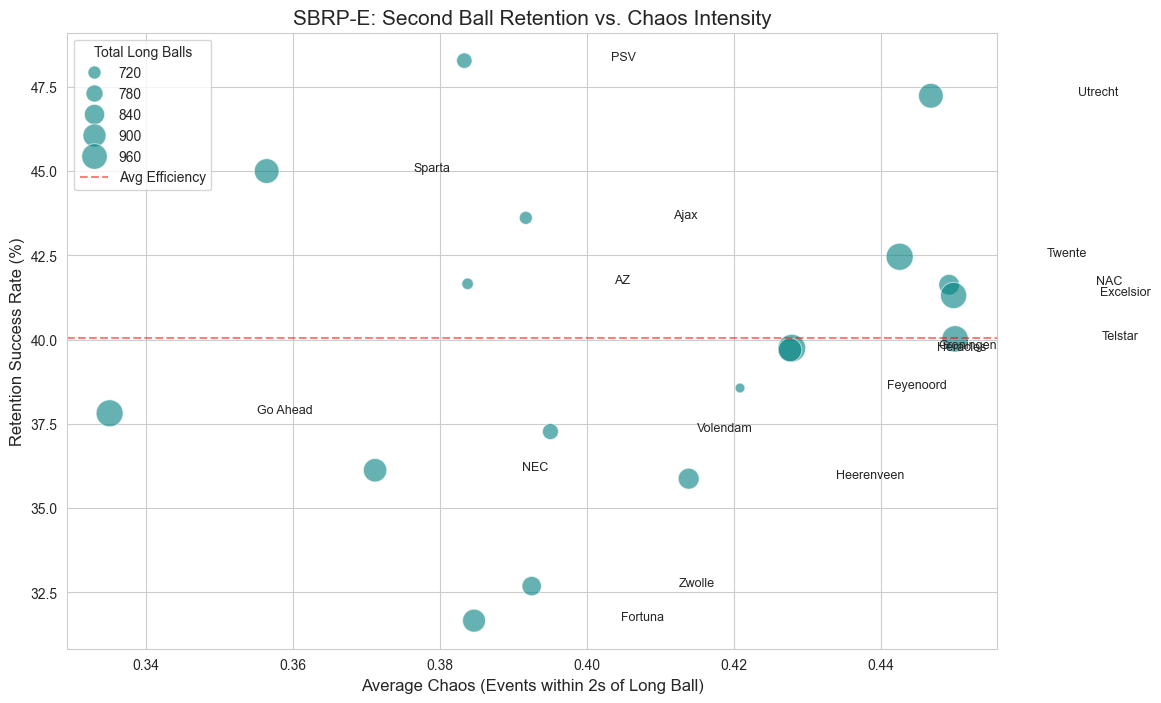

In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from pathlib import Path
from tqdm import tqdm

# --- CONFIGURATION ---
FOLDER_PATH = Path(r'/Users/user/XG/Eredivisie 2025-2026/DONE/') 
MAPPING_FILE = Path(r'/Users/user/XG/Eredivisie 2025-2026 Matches.csv')
OUTPUT_PATH = Path('/Users/user/combined_sbrp_results.csv')

DELTA_T = 5.0  # Window for retention
CHAOS_T = 2.0  # Window for "Chaos" intensity
CONTROLLED_IDS = {1, 3, 4, 7, 8, 10, 13, 14, 15, 16, 49}

def calculate_sbrp_e(file_path):
    """Processes an individual JSON file with optimized window searching."""
    try:
        with open(file_path, 'r') as f:
            data = json.load(f)
    except Exception:
        return pd.DataFrame()
    
    events_list = data.get('event', [])
    if not events_list: return pd.DataFrame()
        
    df = pd.DataFrame(events_list)
    df['timeStamp'] = pd.to_datetime(df['timeStamp'], format='ISO8601')
    
    # Identify Long Balls (typeId 1 + qualifierId 1)
    # We use a helper to check qualifiers efficiently
    is_long_ball = (df['typeId'] == 1) & df['qualifier'].apply(
        lambda x: any(q.get('qualifierId') == 1 for q in x) if isinstance(x, list) else False
    )
    
    long_balls = df[is_long_ball].copy()
    results = []

    for idx, lb in long_balls.iterrows():
        start_time = lb['timeStamp']
        end_time = start_time + timedelta(seconds=DELTA_T)
        chaos_limit = start_time + timedelta(seconds=CHAOS_T)
        
        # Look ahead at the next few events (slices are faster than global filters)
        window = df.iloc[idx + 1 : idx + 15]
        window = window[window['timeStamp'] <= end_time]
        
        if window.empty:
            continue

        # 1. Determine Outcome (Retention)
        # Find first event in window that matches controlled_ids
        retention_event = window[window['typeId'].isin(CONTROLLED_IDS)].head(1)
        
        outcome = 0
        if not retention_event.empty:
            outcome = 1 if retention_event.iloc[0]['contestantId'] == lb['contestantId'] else 0
                
        # 2. Chaos Metric (Density of events in the immediate 2s scramble)
        chaos_count = len(window[window['timeStamp'] <= chaos_limit])
        
        results.append({
            'team_id': lb['contestantId'], 
            'outcome': outcome, 
            'chaos': chaos_count,
            'x': lb.get('x', 0),
            'y': lb.get('y', 0)
        })
        
    return pd.DataFrame(results)

def run_combined_analysis():
    # 1. Build Team Map
    team_map = {}
    if MAPPING_FILE.exists():
        map_df = pd.read_csv(MAPPING_FILE)
        # Handle Opta's nested JSON-to-CSV structure
        for i in range(2):
            id_col, name_col = f"matchInfo/contestant/{i}/id", f"matchInfo/contestant/{i}/shortName"
            if id_col in map_df.columns:
                team_map.update(dict(zip(map_df[id_col], map_df[name_col])))

    # 2. Iterate Files with Progress Bar
    all_dfs = []
    json_files = list(FOLDER_PATH.glob('*.json'))
    
    print(f"Analyzing {len(json_files)} matches...")
    for json_file in tqdm(json_files):
        all_dfs.append(calculate_sbrp_e(json_file))
            
    if not all_dfs:
        print("No data found.")
        return
        
    # 3. Aggregate Results
    full_df = pd.concat(all_dfs)
    full_df['team_name'] = full_df['team_id'].map(team_map).fillna(full_df['team_id'])
    
    analysis = full_df.groupby('team_name').agg(
        long_balls=('outcome', 'count'),
        retained=('outcome', 'sum'),
        avg_chaos=('chaos', 'mean')
    ).reset_index()
    
    analysis['SBRP_E_Score'] = (analysis['retained'] / analysis['long_balls']) * 100
    
    # 4. Filter out teams with low sample size (e.g., < 10 long balls)
    analysis = analysis[analysis['long_balls'] > 10].sort_values('SBRP_E_Score', ascending=False)
    
    print("\n--- FINAL SBRP-E RANKINGS ---")
    print(analysis[['team_name', 'long_balls', 'avg_chaos', 'SBRP_E_Score']])
    
    # 5. Export and Plot
    analysis.to_csv(OUTPUT_PATH, index=False)
    plot_results(analysis)

def plot_results(df):
    """Generates a scatter plot of Chaos vs Efficiency."""
    plt.figure(figsize=(12, 8))
    sns.set_style("whitegrid")
    
    plot = sns.scatterplot(
        data=df, x='avg_chaos', y='SBRP_E_Score', 
        size='long_balls', sizes=(50, 400), alpha=0.6, color='teal'
    )
    
    # Add labels to points
    for i in range(df.shape[0]):
        plt.text(df.avg_chaos[i]+0.02, df.SBRP_E_Score[i], df.team_name[i], fontsize=9)

    plt.title('SBRP-E: Second Ball Retention vs. Chaos Intensity', fontsize=15)
    plt.xlabel('Average Chaos (Events within 2s of Long Ball)', fontsize=12)
    plt.ylabel('Retention Success Rate (%)', fontsize=12)
    plt.axhline(df['SBRP_E_Score'].mean(), color='red', linestyle='--', alpha=0.5, label='Avg Efficiency')
    plt.legend(title='Total Long Balls')
    plt.show()

if __name__ == "__main__":
    run_combined_analysis()

Extracting features from 143 matches...


100%|██████████| 143/143 [00:50<00:00,  2.85it/s]



Analysis complete. Report saved to /Users/user/Eredivisie_xSBR_Zonal_Report.xlsx


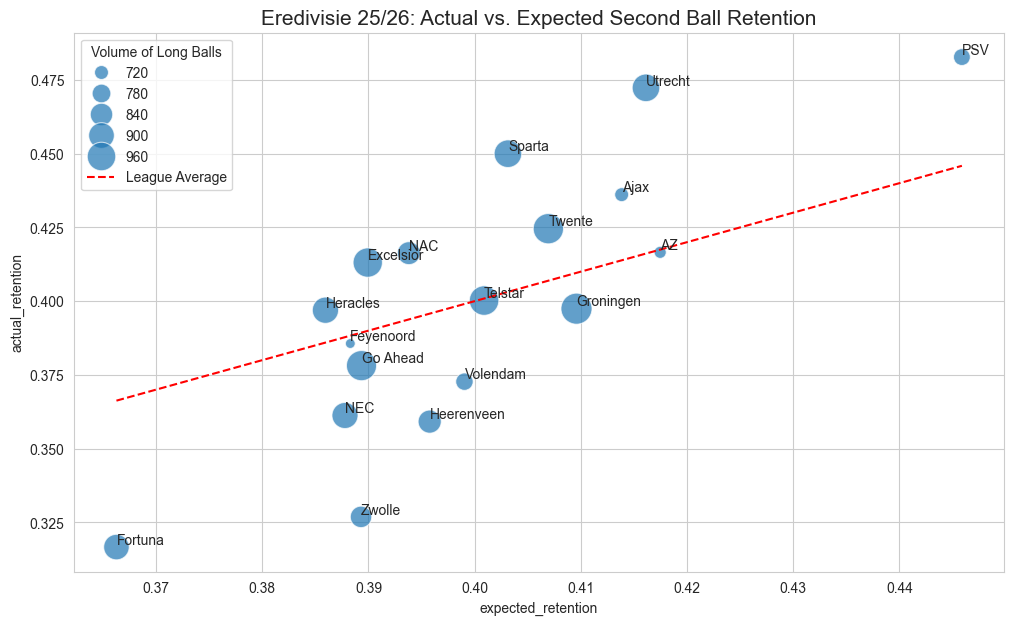

In [5]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import timedelta
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# --- CONFIGURATION ---
FOLDER_PATH = Path(r'/Users/user/XG/Eredivisie 2025-2026/DONE/')
MAPPING_FILE = Path(r'/Users/user/XG/Eredivisie 2025-2026 Matches.csv')
OUTPUT_EXCEL = Path('/Users/user/Eredivisie_xSBR_Zonal_Report.xlsx')

DELTA_T = 5.0
CONTROLLED_IDS = {1, 3, 4, 7, 8, 10, 13, 14, 15, 16, 49}

# 1. DATA EXTRACTION & FEATURE ENGINEERING
def extract_model_data():
    all_rows = []
    json_files = list(FOLDER_PATH.glob('*.json'))
    
    print(f"Extracting features from {len(json_files)} matches...")
    for file_path in tqdm(json_files):
        try:
            with open(file_path, 'r') as f:
                data = json.load(f)
            events = pd.DataFrame(data.get('event', []))
            events['timeStamp'] = pd.to_datetime(events['timeStamp'], format='ISO8601')
            match_id = data.get('matchInfo', {}).get('id', file_path.stem)
        except: continue

        is_long_ball = (events['typeId'] == 1) & events['qualifier'].apply(
            lambda x: any(q.get('qualifierId') == 1 for q in x) if isinstance(x, list) else False
        )
        
        for idx, lb in events[is_long_ball].iterrows():
            start_t = lb['timeStamp']
            window = events.iloc[idx + 1 : idx + 12]
            window = window[(window['timeStamp'] - start_t).dt.total_seconds() <= DELTA_T]
            
            if window.empty: continue

            retention_ev = window[window['typeId'].isin(CONTROLLED_IDS)].head(1)
            outcome = 0
            if not retention_ev.empty:
                outcome = 1 if retention_ev.iloc[0]['contestantId'] == lb['contestantId'] else 0

            x, y = lb.get('x', 50), lb.get('y', 50)
            end_x = next((q.get('value') for q in lb['qualifier'] if q.get('qualifierId') == 140), x + 30)
            end_y = next((q.get('value') for q in lb['qualifier'] if q.get('qualifierId') == 141), y)
            
            try:
                pass_len = np.sqrt((float(end_x) - x)**2 + (float(end_y) - y)**2)
                pass_angle = np.arctan2(float(end_y) - y, float(end_x) - x)
            except: pass_len, pass_angle = 35.0, 0.0

            all_rows.append({
                'match_id': match_id,
                'team_id': lb['contestantId'],
                'outcome': outcome,
                'start_x': x,
                'start_y': y,
                'end_x': float(end_x),
                'end_y': float(end_y),
                'pass_len': pass_len,
                'pass_angle': pass_angle,
                'chaos': len(window)
            })
            
    return pd.DataFrame(all_rows)

# 2. ANALYSIS & EXPORT
def run_full_xsbr_analysis():
    df = extract_model_data()
    
    # Feature selection & Training
    features = ['start_x', 'start_y', 'end_x', 'end_y', 'pass_len', 'pass_angle', 'chaos']
    X = df[features]
    y = df['outcome']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = RandomForestClassifier(n_estimators=200, max_depth=7, random_state=42)
    model.fit(X_train, y_train)

    # Predictions
    df['xSBR'] = model.predict_proba(X)[:, 1]
    df['SBR_Added'] = df['outcome'] - df['xSBR']

    # Zonal Categorization
    conditions = [ (df['start_x'] < 33.3), (df['start_x'] < 66.6), (df['start_x'] >= 66.6) ]
    choices = ['Defensive Third', 'Middle Third', 'Attacking Third']
    df['zone'] = np.select(conditions, choices, default='Middle Third')

    # Team Mapping
    team_map = {}
    if MAPPING_FILE.exists():
        map_df = pd.read_csv(MAPPING_FILE)
        for i in range(2):
            id_col, name_col = f"matchInfo/contestant/{i}/id", f"matchInfo/contestant/{i}/shortName"
            if id_col in map_df.columns:
                team_map.update(dict(zip(map_df[id_col], map_df[name_col])))
    df['team_name'] = df['team_id'].map(team_map).fillna(df['team_id'])

    # Aggregate Overall
    overall_report = df.groupby('team_name').agg(
        total_long_balls=('outcome', 'count'),
        actual_retention=('outcome', 'mean'),
        expected_retention=('xSBR', 'mean'),
        net_sbr_added=('SBR_Added', 'sum'),
        avg_chaos=('chaos', 'mean')
    ).reset_index().sort_values('net_sbr_added', ascending=False)

    # Aggregate Zonal
    zonal_report = df.groupby(['team_name', 'zone']).agg(
        balls=('outcome', 'count'),
        success_rate=('outcome', 'mean'),
        sbr_added=('SBR_Added', 'sum')
    ).reset_index()

    # 3. SAVE TO EXCEL
    with pd.ExcelWriter(OUTPUT_EXCEL, engine='openpyxl') as writer:
        overall_report.to_excel(writer, sheet_name='League_Rankings', index=False)
        for zone_name in choices:
            zone_df = zonal_report[zonal_report['zone'] == zone_name].sort_values('sbr_added', ascending=False)
            zone_df.to_excel(writer, sheet_name=zone_name.replace(" ", "_"), index=False)
    
    print(f"\nAnalysis complete. Report saved to {OUTPUT_EXCEL}")
    
    plot_xsbr(overall_report)
    return df, model

def plot_xsbr(df):
    plt.figure(figsize=(12, 7))
    sns.set_style("whitegrid")
    sns.scatterplot(data=df, x='expected_retention', y='actual_retention', 
                    size='total_long_balls', sizes=(50, 500), alpha=0.7)
    
    line_coords = [df['expected_retention'].min(), df['expected_retention'].max()]
    plt.plot(line_coords, line_coords, color='red', linestyle='--', label='League Average')
    
    for i in range(df.shape[0]):
        plt.text(df.expected_retention.iloc[i], df.actual_retention.iloc[i], 
                 df.team_name.iloc[i], fontsize=10, va='bottom')
        
    plt.title('Eredivisie 25/26: Actual vs. Expected Second Ball Retention', fontsize=15)
    plt.legend(title="Volume of Long Balls")
    plt.show()

if __name__ == "__main__":
    final_df, trained_model = run_full_xsbr_analysis()

100%|██████████| 143/143 [00:20<00:00,  6.84it/s]


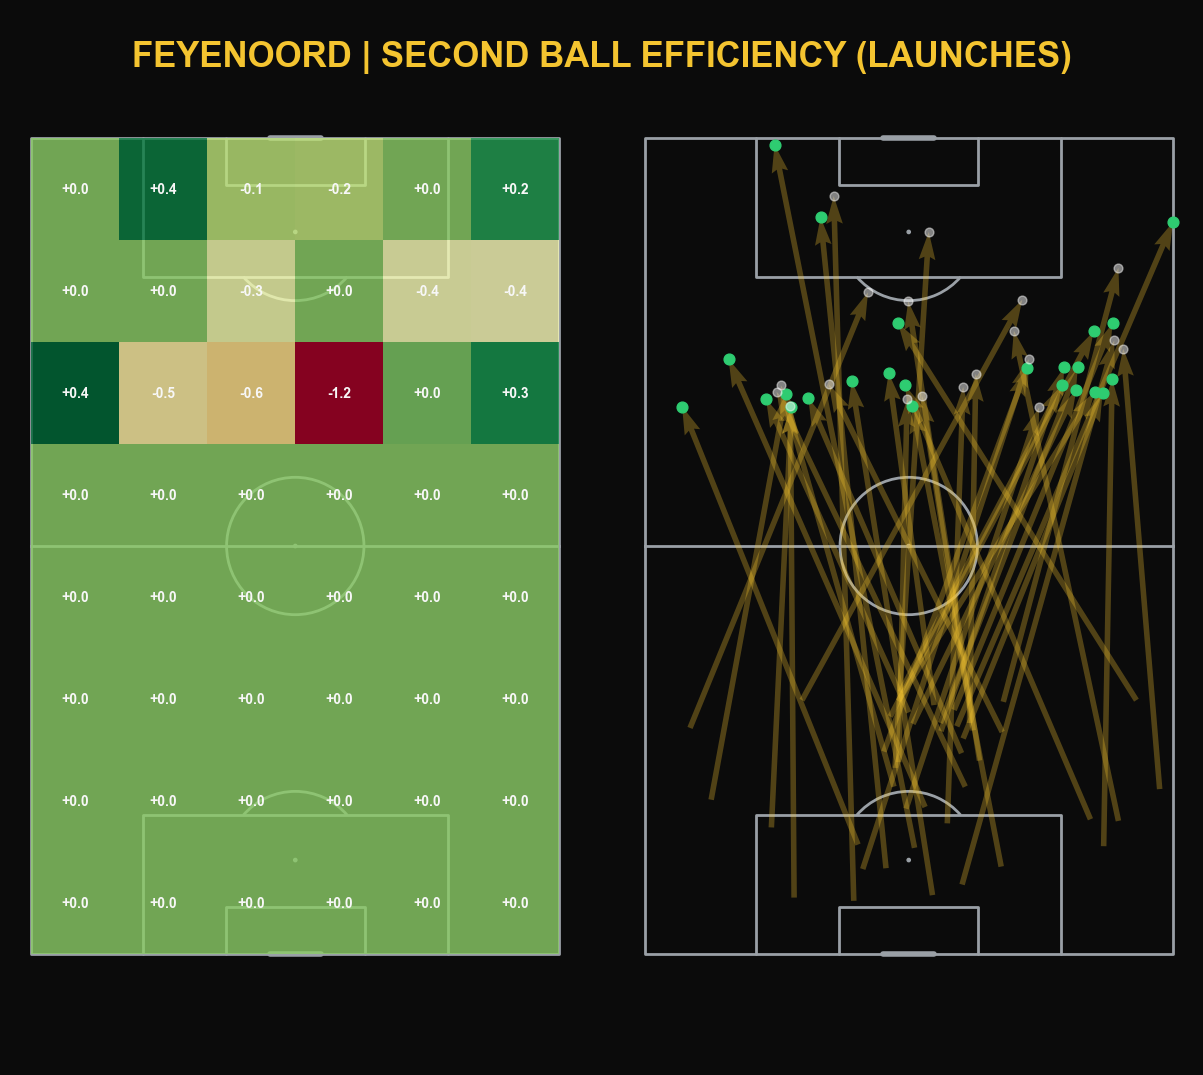

In [ ]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import timedelta
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from mplsoccer import Pitch

# --- CONFIGURATION ---
FOLDER_PATH = Path(r'/Users/user/XG/Eredivisie 2025-2026/DONE/')
MAPPING_FILE = Path(r'/Users/user/XG/Eredivisie 2025-2026 Matches.csv')
OUTPUT_EXCEL = Path('/Users/user/Eredivisie_xSBR_Zonal_Report.xlsx')

DELTA_T = 5.0
CONTROLLED_IDS = {1, 3, 4, 7, 8, 10, 13, 14, 15, 16, 49}

# 1. DATA EXTRACTION & FEATURE ENGINEERING
def extract_model_data():
    all_rows = []
    json_files = list(FOLDER_PATH.glob('*.json'))
    
    print(f"Extracting features from {len(json_files)} matches...")
    for file_path in tqdm(json_files):
        try:
            with open(file_path, 'r') as f:
                data = json.load(f)
            events = pd.DataFrame(data.get('event', []))
            events['timeStamp'] = pd.to_datetime(events['timeStamp'], format='ISO8601')
            match_id = data.get('matchInfo', {}).get('id', file_path.stem)
        except: continue

        # Filter for Long Balls: typeId 1 (Pass) and qualifierId 1 (Long Ball)
        is_long_ball = (events['typeId'] == 1) & events['qualifier'].apply(
            lambda x: any(q.get('qualifierId') == 1 for q in x) if isinstance(x, list) else False
        )
        
        for idx, lb in events[is_long_ball].iterrows():
            start_t = lb['timeStamp']
            # Window check for next controlled action (retention)
            window = events.iloc[idx + 1 : idx + 12]
            window = window[(window['timeStamp'] - start_t).dt.total_seconds() <= DELTA_T]
            
            if window.empty: continue

            # Determine Outcome
            retention_ev = window[window['typeId'].isin(CONTROLLED_IDS)].head(1)
            outcome = 1 if (not retention_ev.empty and retention_ev.iloc[0]['contestantId'] == lb['contestantId']) else 0

            # Features for Model
            x, y = lb.get('x', 50), lb.get('y', 50)
            end_x = next((q.get('value') for q in lb['qualifier'] if q.get('qualifierId') == 140), x + 30)
            end_y = next((q.get('value') for q in lb['qualifier'] if q.get('qualifierId') == 141), y)
            
            try:
                pass_len = np.sqrt((float(end_x) - x)**2 + (float(end_y) - y)**2)
                pass_angle = np.arctan2(float(end_y) - y, float(end_x) - x)
            except: pass_len, pass_angle = 35.0, 0.0

            all_rows.append({
                'match_id': match_id,
                'team_id': lb['contestantId'],
                'outcome': outcome,
                'start_x': x,
                'start_y': y,
                'end_x': float(end_x),
                'end_y': float(end_y),
                'pass_len': pass_len,
                'pass_angle': pass_angle,
                'chaos': len(window)
            })
            
    return pd.DataFrame(all_rows)

# 2. ANALYSIS & EXPORT
def run_full_xsbr_analysis():
    df = extract_model_data()
    features = ['start_x', 'start_y', 'end_x', 'end_y', 'pass_len', 'pass_angle', 'chaos']
    X, y = df[features], df['outcome']

    # Train Random Forest
    model = RandomForestClassifier(n_estimators=200, max_depth=7, random_state=42)
    model.fit(X, y)

    # Calculate xSBR and SBR-Added
    df['xSBR'] = model.predict_proba(X)[:, 1]
    df['SBR_Added'] = df['outcome'] - df['xSBR']

    # Zonal Categorization for Excel
    conditions = [ (df['start_x'] < 33.3), (df['start_x'] < 66.6), (df['start_x'] >= 66.6) ]
    choices = ['Defensive Third', 'Middle Third', 'Attacking Third']
    df['zone'] = np.select(conditions, choices, default='Middle Third')

    # Team Mapping
    team_map = {}
    if MAPPING_FILE.exists():
        map_df = pd.read_csv(MAPPING_FILE)
        for i in range(2):
            id_col, name_col = f"matchInfo/contestant/{i}/id", f"matchInfo/contestant/{i}/shortName"
            if id_col in map_df.columns:
                team_map.update(dict(zip(map_df[id_col], map_df[name_col])))
    df['team_name'] = df['team_id'].map(team_map).fillna(df['team_id'])

    # Aggregate Overall
    overall_report = df.groupby('team_name').agg(
        total_long_balls=('outcome', 'count'),
        actual_retention=('outcome', 'mean'),
        expected_retention=('xSBR', 'mean'),
        net_sbr_added=('SBR_Added', 'sum')
    ).reset_index().sort_values('net_sbr_added', ascending=False)

    # Save to Excel
    with pd.ExcelWriter(OUTPUT_EXCEL, engine='openpyxl') as writer:
        overall_report.to_excel(writer, sheet_name='League_Rankings', index=False)
        for zone_name in choices:
            z_df = df[df['zone'] == zone_name].groupby('team_name')['SBR_Added'].sum().reset_index()
            z_df.to_excel(writer, sheet_name=zone_name.replace(" ", "_"), index=False)

    return df, model

# 3. PITCH VISUALIZATION
def plot_team_performance_map(full_df, team_name, model):
    team_df = full_df[full_df['team_name'] == team_name].copy()
    pitch = Pitch(pitch_type='opta', line_color='#7c7c7c', pitch_color='#1a1a1a', line_zorder=2)
    fig, ax = pitch.draw(figsize=(14, 10))
    fig.set_facecolor('#1a1a1a')

    # Generate Surface xSBR (Background)
    x_grid, y_grid = np.linspace(0, 100, 50), np.linspace(0, 100, 50)
    xx, yy = np.meshgrid(x_grid, y_grid)
    grid_df = pd.DataFrame({
        'start_x': xx.ravel() - 35, 'start_y': yy.ravel(),
        'end_x': xx.ravel(), 'end_y': yy.ravel(),
        'pass_len': 40.0, 'pass_angle': 0.0, 'chaos': 4.0
    })
    zz = model.predict_proba(grid_df)[:, 1].reshape(xx.shape)
    
    # Corrected: Call contourf on the axes (ax)
    ax.contourf(xx, yy, zz, cmap='RdYlGn', alpha=0.3, levels=10, zorder=1)

    # Plot Feyenoord Events
    pitch.scatter(team_df[team_df['outcome']==1].end_x, team_df[team_df['outcome']==1].end_y, 
                  color='#00ff41', s=80, label='Retained', alpha=0.8, ax=ax, zorder=3)
    pitch.scatter(team_df[team_df['outcome']==0].end_x, team_df[team_df['outcome']==0].end_y, 
                  color='#ff003c', s=60, label='Lost', alpha=0.4, ax=ax, zorder=2)

    # Add Three Thirds Lines & Annotations
    ax.axvline(33.3, color='white', linestyle='--', alpha=0.5, lw=2)
    ax.axvline(66.6, color='white', linestyle='--', alpha=0.5, lw=2)
    ax.text(16, 5, 'DEFENSIVE', color='white', ha='center', fontsize=12, fontweight='bold')
    ax.text(50, 5, 'MIDDLE', color='white', ha='center', fontsize=12, fontweight='bold')
    ax.text(83, 5, 'ATTACKING', color='white', ha='center', fontsize=12, fontweight='bold')

    plt.title(f'{team_name} | xSBR Performance & Landing Zones', color='white', fontsize=20)
    plt.legend(loc='lower right')
    plt.show()

if __name__ == "__main__":
    final_df, trained_model = run_full_xsbr_analysis()
    plot_team_performance_map(final_df, "Feyenoord", trained_model)

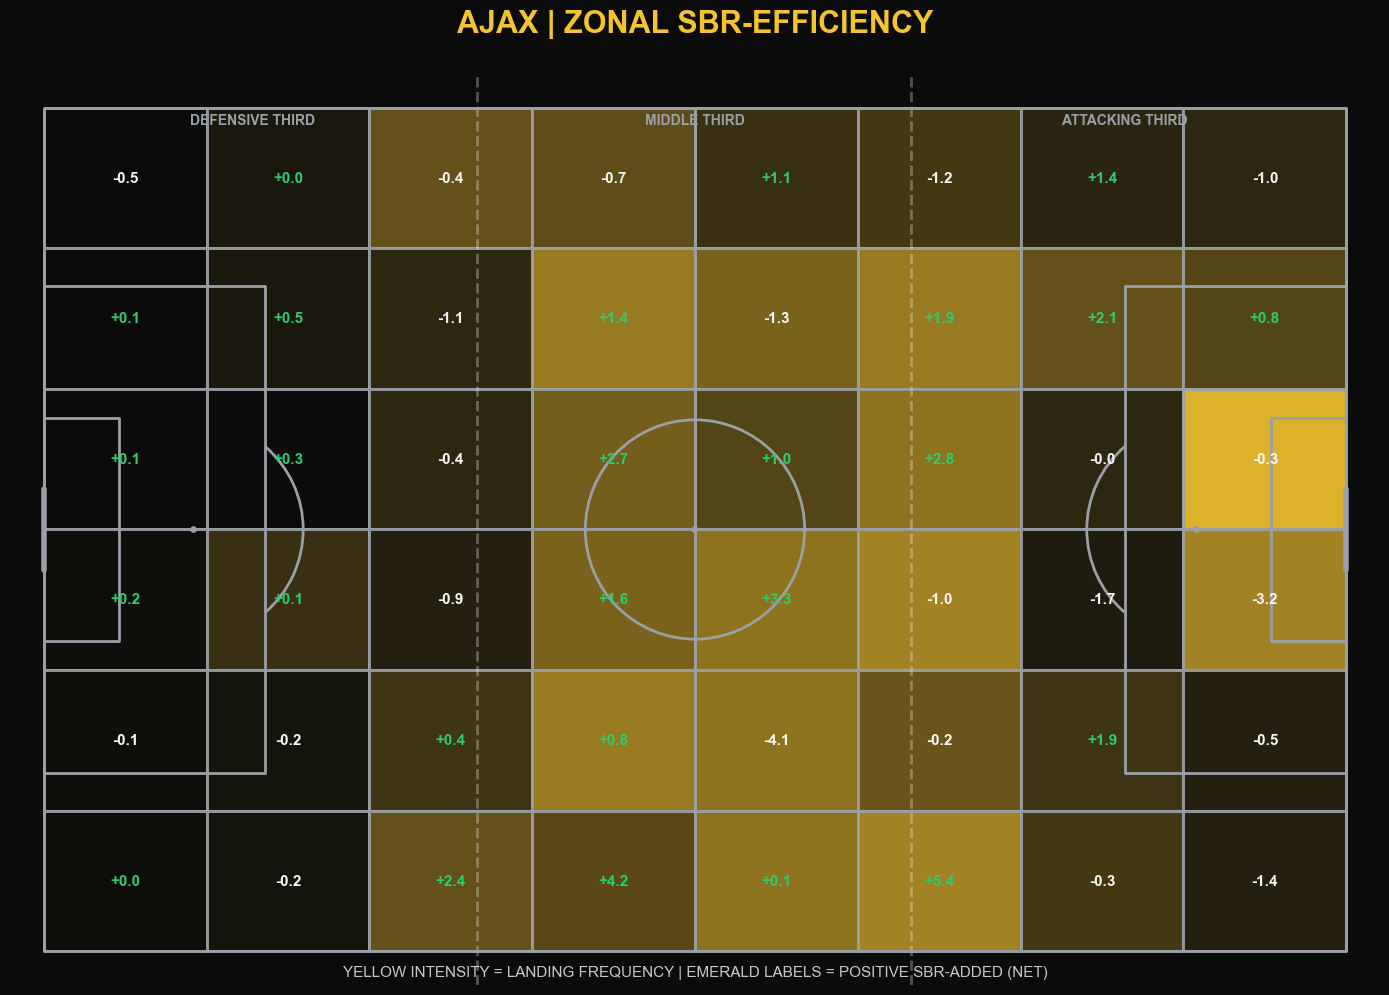

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from mplsoccer import Pitch

# --- 1. CONFIGURATIE & KLEUREN ---
COLORS = {
    'yellow': '#F4C430',
    'black': '#0B0B0B',
    'white': '#F7F7F7',
    'grey': '#9AA0A6',
    'emerald': '#2ECC71',
    'blue': '#3498DB'
}

def plot_custom_binned_heatmap(full_df, team_name):
    # 1. Filter for Team
    team_df = full_df[full_df['team_name'] == team_name].copy()
    if team_df.empty:
        print(f"No data for {team_name}")
        return

    # 2. Create Custom Colormap (Black -> Yellow)
    custom_cmap = LinearSegmentedColormap.from_list('density_map', [COLORS['black'], COLORS['yellow']])

    # 3. Setup Pitch
    pitch = Pitch(pitch_type='opta', 
                  line_color=COLORS['grey'], 
                  pitch_color=COLORS['black'], 
                  line_zorder=3)
    
    fig, ax = pitch.draw(figsize=(14, 10))
    fig.set_facecolor(COLORS['black'])

    # 4. Bin Statistic for Volume (The Colors) - 8x6 grid
    bin_vol = pitch.bin_statistic(team_df.end_x, team_df.end_y, 
                                  statistic='count', 
                                  bins=(8, 6))

    # Draw Heatmap
    pcm = pitch.heatmap(bin_vol, ax=ax, cmap=custom_cmap, edgecolors=COLORS['grey'], alpha=0.9)
    
    # 5. Bin Statistic for SBR-Added (The Values)
    bin_added = pitch.bin_statistic(team_df.end_x, team_df.end_y, 
                                    values=team_df.SBR_Added, 
                                    statistic='sum', 
                                    bins=(8, 6))

    # 6. Annotate with SBR-Added values safely
    # We iterate through the underlying 2D array ('statistic')
    # bin_added['cx'] and bin_added['cy'] provide the center of each bin
    stat_values = bin_added['statistic']
    cx = bin_added['cx']
    cy = bin_added['cy']

    for i in range(stat_values.shape[0]):
        for j in range(stat_values.shape[1]):
            val = stat_values[i, j]
            if not np.isnan(val) and bin_vol['statistic'][i, j] > 0:
                # Color logic: Emerald for positive SBR-Added, White for negative
                text_val_color = COLORS['emerald'] if val > 0 else COLORS['white']
                
                # Placing text using the bin centers (cx, cy)
                ax.text(cx[i, j], cy[i, j],
                        f"{val:+.1f}",
                        color=text_val_color, 
                        fontsize=11, 
                        fontweight='bold',
                        ha='center', 
                        va='center', 
                        zorder=4)

    # 7. Add Tactical Dividers (Thirds)
    ax.axvline(33.3, color=COLORS['white'], linestyle='--', alpha=0.3, lw=2)
    ax.axvline(66.6, color=COLORS['white'], linestyle='--', alpha=0.3, lw=2)

    # Labels for the Thirds
    ax.text(16, 98, 'DEFENSIVE THIRD', color=COLORS['grey'], ha='center', fontsize=10, fontweight='bold')
    ax.text(50, 98, 'MIDDLE THIRD', color=COLORS['grey'], ha='center', fontsize=10, fontweight='bold')
    ax.text(83, 98, 'ATTACKING THIRD', color=COLORS['grey'], ha='center', fontsize=10, fontweight='bold')

    # 8. Titles & Legend
    plt.title(f'{team_name.upper()} | ZONAL SBR-EFFICIENCY', color=COLORS['yellow'], fontsize=22, pad=30, fontweight='bold')
    plt.text(50, -3, "YELLOW INTENSITY = LANDING FREQUENCY | EMERALD LABELS = POSITIVE SBR-ADDED (NET)", 
             color=COLORS['white'], ha='center', fontsize=11, alpha=0.8)

    plt.show()

# --- RUN ---
plot_custom_binned_heatmap(final_df, "Ajax")

Extracting features from 143 matches...


100%|██████████| 143/143 [00:51<00:00,  2.77it/s]


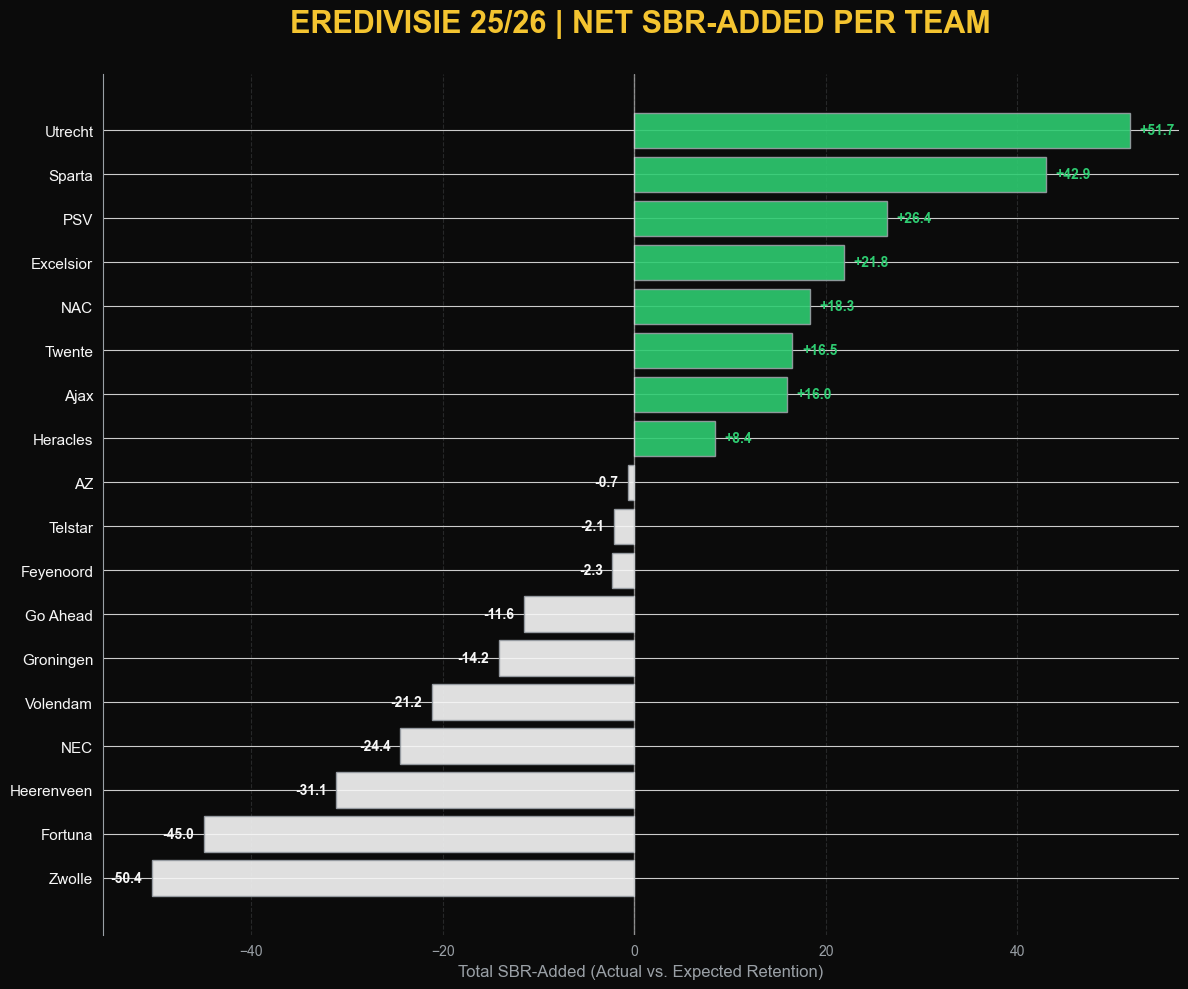

In [22]:
# 1. Run the analysis and capture the results
# Your function returns: (processed_dataframe, trained_model)
# We also need to generate the 'overall_report' from that dataframe
final_df, trained_model = run_full_xsbr_analysis()

# 2. Re-create the overall_report grouping (if not already returned by your function)
overall_report = final_df.groupby('team_name').agg(
    total_long_balls=('outcome', 'count'),
    actual_retention=('outcome', 'mean'),
    expected_retention=('xSBR', 'mean'),
    net_sbr_added=('SBR_Added', 'sum')
).reset_index()

# 3. Now run the bar graph
plot_league_sbr_added(overall_report)

OSError: [Errno 30] Read-only file system: '/Ajax_Strategic_Report.png'

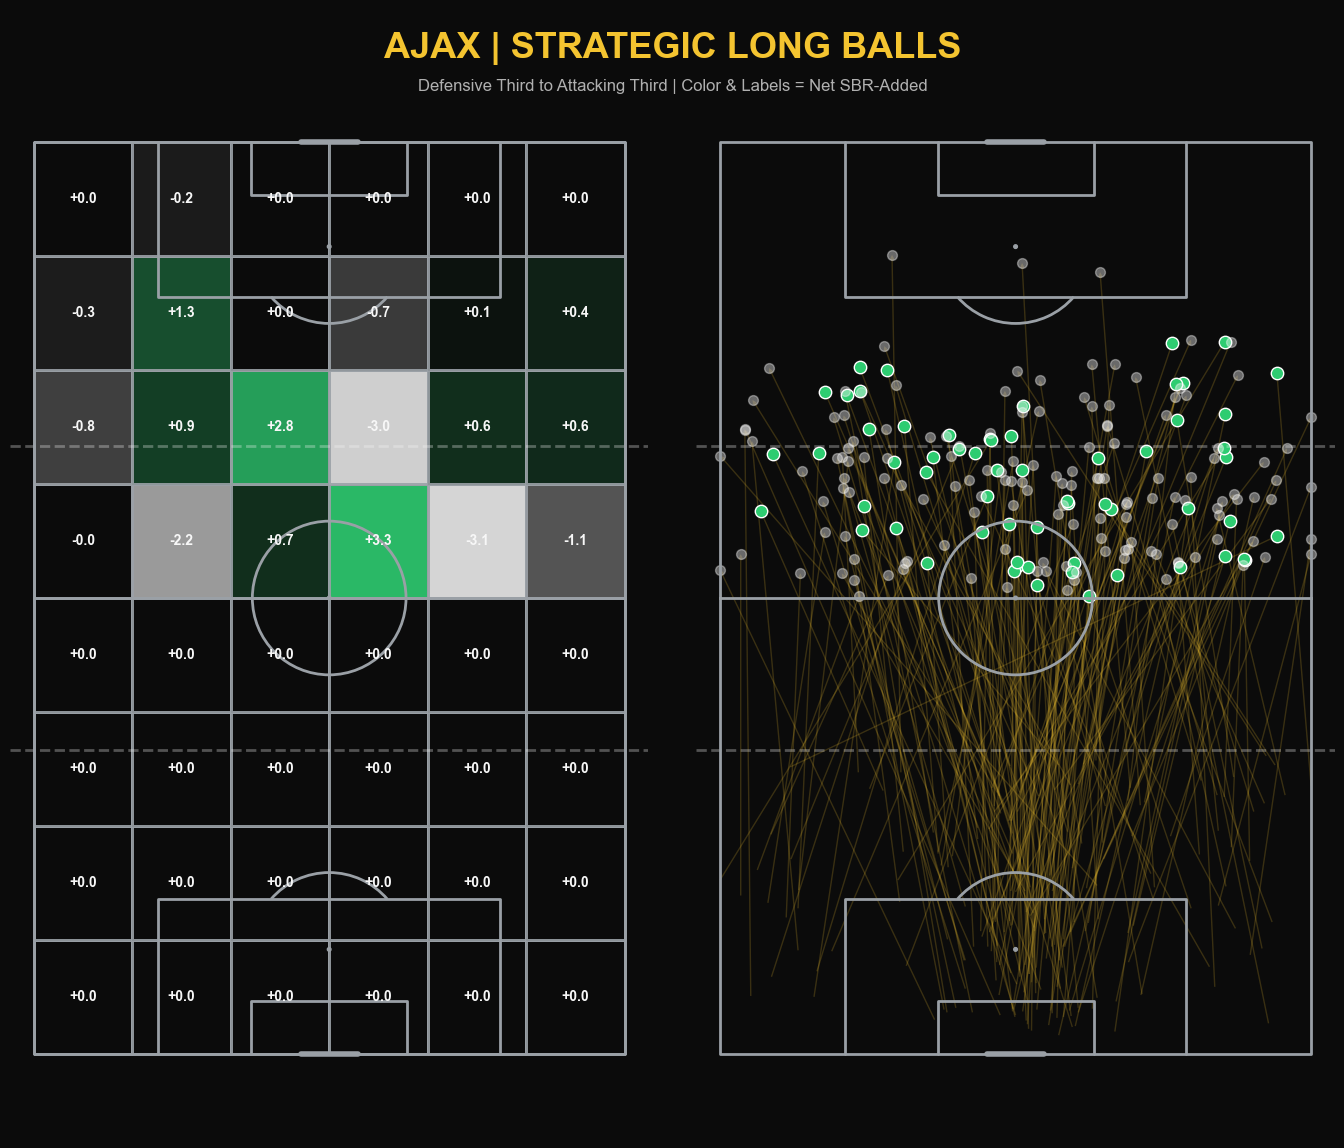

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from mplsoccer import VerticalPitch
from pathlib import Path

# --- 1. CONFIGURATION & PALETTE ---
COLORS = {
    'yellow': '#F4C430',
    'black': '#0B0B0B',
    'white': '#F7F7F7',
    'grey': '#9AA0A6',
    'emerald': '#2ECC71',
    'blue': '#3498DB'
}

def plot_final_vertical_report(full_df, team_name):
    # Filter for Team
    team_df = full_df[full_df['team_name'] == team_name].copy()
    
    # STRATEGIC FILTER: Long Launches (Defensive Third -> Attacking Third)
    # Opta coordinates: Defensive (x < 33.3), Attacking (x > 66.6)
    strategic_df = team_df[(team_df['start_x'] < 33.3) & (team_df['end_x'] > 50)].copy()

    if strategic_df.empty:
        print(f"No qualifying long balls found for {team_name}.")
        return

    # Setup Vertical Pitch
    pitch = VerticalPitch(pitch_type='opta', line_color=COLORS['grey'], 
                          pitch_color=COLORS['black'], line_zorder=3)
    
    # Create a 1x2 grid for Heatmap and Trajectories
    fig, axs = pitch.grid(nrows=1, ncols=2, figheight=12, grid_height=0.8, 
                          axis=False, title_height=0.08, endnote_height=0.04)
    fig.set_facecolor(COLORS['black'])

    # --- BINS SYNCHRONIZATION ---
    # We use (8 bins vertical, 6 bins horizontal)
    # values=strategic_df.SBR_Added ensures the color represents efficiency
    bin_stat = pitch.bin_statistic(strategic_df.end_x, strategic_df.end_y, 
                                   values=strategic_df.SBR_Added, 
                                   statistic='sum', bins=(8, 6))

    # --- LEFT PLOT: EFFICIENCY HEATMAP ---
    # Create a Diverging Colormap: Red (Underperform) -> Black (Neutral) -> Emerald (Elite)
    div_cmap = LinearSegmentedColormap.from_list('efficiency', [COLORS['white'], COLORS['black'], COLORS['emerald']])
    
    # Symmetric normalization so 0.0 is always Black
    vmax = max(abs(bin_stat['statistic'].max()), abs(bin_stat['statistic'].min()), 1.0)
    
    pitch.heatmap(bin_stat, ax=axs['pitch'][0], cmap=div_cmap, 
                  edgecolors=COLORS['grey'], vmin=-vmax, vmax=vmax, alpha=0.9)
    
    pitch.label_heatmap(bin_stat, ax=axs['pitch'][0], color=COLORS['white'], 
                        fontsize=10, fontweight='bold', str_format='{:+2.1f}',
                        ha='center', va='center')

    # --- RIGHT PLOT: TRAJECTORIES ---
    pitch.arrows(strategic_df.start_x, strategic_df.start_y, 
                 strategic_df.end_x, strategic_df.end_y,
                 width=1, headwidth=3, headlength=3, color=COLORS['yellow'], 
                 alpha=0.2, ax=axs['pitch'][1])
    
    # Success Markers
    retained = strategic_df[strategic_df['outcome'] == 1]
    lost = strategic_df[strategic_df['outcome'] == 0]
    
    pitch.scatter(retained.end_x, retained.end_y, color=COLORS['emerald'], 
                  s=80, edgecolors='white', ax=axs['pitch'][1], label='Retained')
    pitch.scatter(lost.end_x, lost.end_y, color=COLORS['white'], 
                  s=50, alpha=0.4, ax=axs['pitch'][1], label='Lost')

    # --- ANNOTATIONS ---
    for ax in axs['pitch']:
        ax.axhline(33.3, color=COLORS['white'], linestyle='--', alpha=0.3, lw=2)
        ax.axhline(66.6, color=COLORS['white'], linestyle='--', alpha=0.3, lw=2)

    axs['title'].text(0.5, 0.6, f'{team_name.upper()} | STRATEGIC LONG BALLS', 
                      color=COLORS['yellow'], fontsize=26, ha='center', va='center', fontweight='bold')
    axs['title'].text(0.5, 0.2, 'Defensive Third to Attacking Third | Color & Labels = Net SBR-Added', 
                      color=COLORS['white'], ha='center', va='center', fontsize=12, alpha=0.7)

    # SAFE SAVE LOGIC
    output_name = f"{team_name.replace(' ', '_')}_Strategic_Report.png"
    save_path = Path.cwd() / output_name
    plt.savefig(save_path, dpi=300, facecolor=COLORS['black'], bbox_inches='tight')
    print(f"Strategic Report saved to: {save_path}")
    plt.show()

# --- EXECUTION ---
plot_final_vertical_report(final_df, "Ajax")

100%|██████████| 143/143 [00:20<00:00,  7.06it/s]


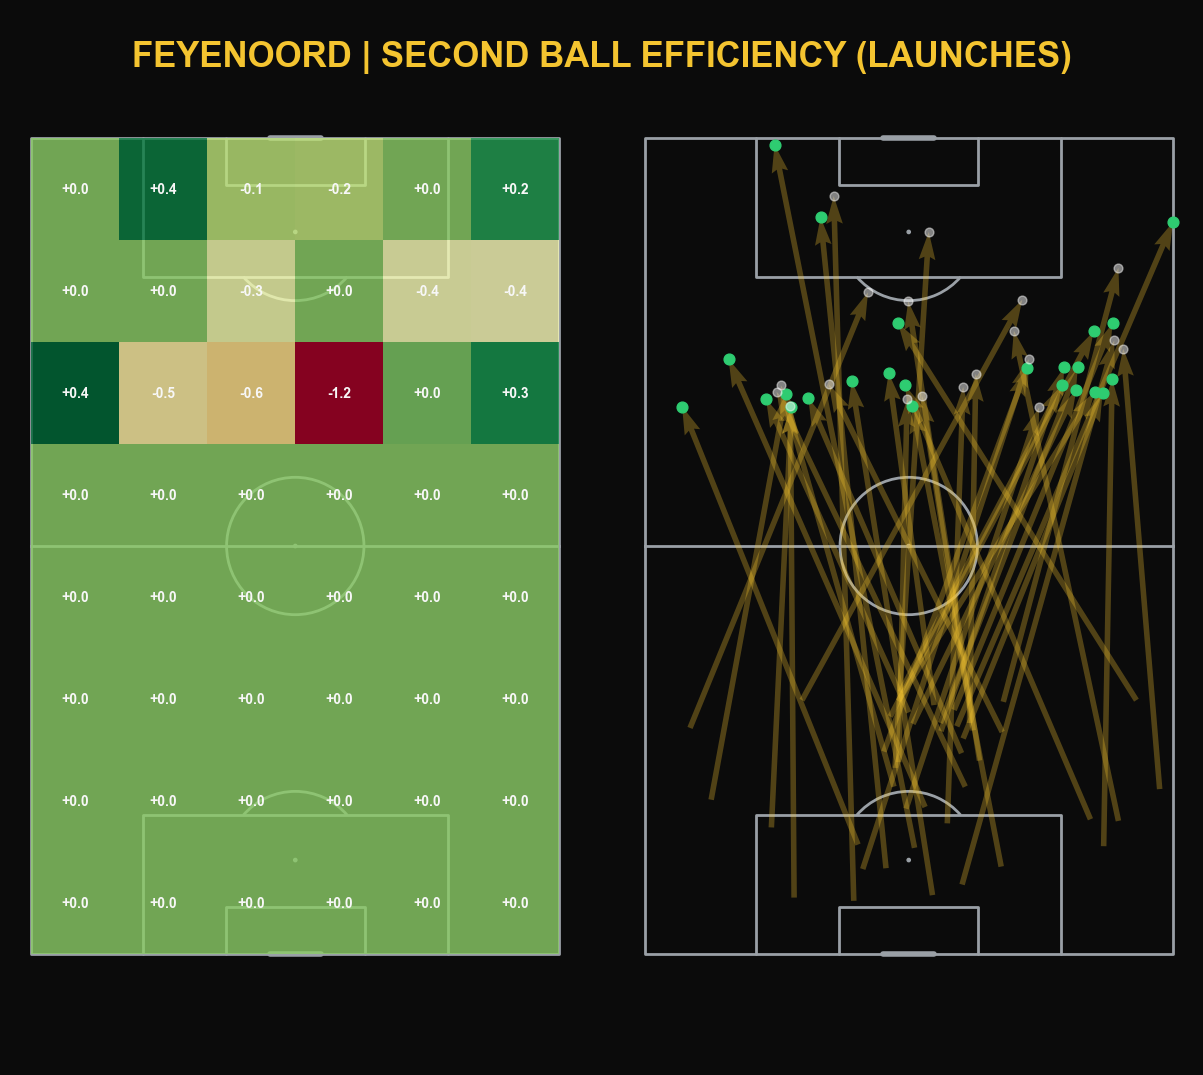

In [31]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from mplsoccer import VerticalPitch, Pitch

# --- CONFIGURATION ---
FOLDER_PATH = Path(r'/Users/user/XG/Eredivisie 2025-2026/DONE/')
MAPPING_FILE = Path(r'/Users/user/XG/Eredivisie 2025-2026 Matches.csv')
COLORS = {'yellow': '#F4C430', 'black': '#0B0B0B', 'white': '#F7F7F7', 'grey': '#9AA0A6', 'emerald': '#2ECC71'}

# 1. UPDATED DATA EXTRACTION (Launch & Second Ball Focus)
def extract_sbr_data():
    all_rows = []
    json_files = list(FOLDER_PATH.glob('*.json'))
    
    for file_path in tqdm(json_files):
        try:
            with open(file_path, 'r') as f:
                data = json.load(f)
            events = pd.DataFrame(data.get('event', []))
            events['timeStamp'] = pd.to_datetime(events['timeStamp'], format='ISO8601')
            match_id = data.get('matchInfo', {}).get('id', file_path.stem)
        except: continue

        # FILTER: Qualifier 157 = Launch (A long ball hit into an area to be contested)
        is_launch = (events['typeId'] == 1) & events['qualifier'].apply(
            lambda x: any(q.get('qualifierId') == 157 for q in x) if isinstance(x, list) else False
        )
        
        for idx, launch in events[is_launch].iterrows():
            # Second ball window: Next 2-3 events within 5 seconds
            # We look for who gains "Controlled Possession" after the air duel
            window = events.iloc[idx + 1 : idx + 6].copy()
            window = window[(window['timeStamp'] - launch['timeStamp']).dt.total_seconds() <= 5.0]
            
            if window.empty: continue

            # Determine Outcome: Did the launching team win the "Second Ball"?
            # We look for the first event that isn't a header/duel (typeId 1, 7, 8 etc.)
            retention_ev = window[window['contestantId'] == launch['contestantId']]
            outcome = 1 if not retention_ev.empty else 0

            # Spatial Features
            x, y = launch.get('x', 50), launch.get('y', 50)
            end_x = next((q.get('value') for q in launch['qualifier'] if q.get('qualifierId') == 140), x + 40)
            end_y = next((q.get('value') for q in launch['qualifier'] if q.get('qualifierId') == 141), y)
            
            all_rows.append({
                'match_id': match_id,
                'team_id': launch['contestantId'],
                'outcome': outcome,
                'start_x': x, 'start_y': y,
                'end_x': float(end_x), 'end_y': float(end_y),
                'chaos': len(window) # Number of players fighting for the ball
            })
            
    return pd.DataFrame(all_rows)

# 2. UPDATED ANALYSIS
def run_sbr_analysis():
    df = extract_sbr_data()
    features = ['start_x', 'start_y', 'end_x', 'end_y', 'chaos']
    X, y = df[features], df['outcome']

    model = RandomForestClassifier(n_estimators=200, max_depth=5, random_state=42)
    model.fit(X, y)

    df['xSBR'] = model.predict_proba(X)[:, 1]
    df['SBR_Added'] = df['outcome'] - df['xSBR']

    # Team Mapping
    team_map = {}
    if MAPPING_FILE.exists():
        map_df = pd.read_csv(MAPPING_FILE)
        # Assuming mapping CSV structure
        for i in range(2):
            id_col, name_col = f"matchInfo/contestant/{i}/id", f"matchInfo/contestant/{i}/shortName"
            if id_col in map_df.columns:
                team_map.update(dict(zip(map_df[id_col], map_df[name_col])))
    df['team_name'] = df['team_id'].map(team_map).fillna(df['team_id'])

    return df, model

# 3. UPDATED VERTICAL STRATEGIC PLOT
def plot_vertical_sbr(full_df, team_name):
    team_df = full_df[full_df['team_name'] == team_name].copy()
    
    # Filter for Defensive -> Attacking launches only
    strategic_df = team_df[(team_df['start_x'] < 33.3) & (team_df['end_x'] > 66.6)]

    pitch = VerticalPitch(pitch_type='opta', line_color=COLORS['grey'], pitch_color=COLORS['black'])
    fig, axs = pitch.grid(nrows=1, ncols=2, figheight=12, axis=False, title_height=0.08)
    fig.set_facecolor(COLORS['black'])

    # Heatmap of Efficiency (Net SBR-Added)
    bin_stat = pitch.bin_statistic(strategic_df.end_x, strategic_df.end_y, 
                                   values=strategic_df.SBR_Added, statistic='sum', bins=(8, 6))
    
    pitch.heatmap(bin_stat, ax=axs['pitch'][0], cmap='RdYlGn', alpha=0.8)
    pitch.label_heatmap(bin_stat, ax=axs['pitch'][0], color=COLORS['white'], str_format='{:+2.1f}', fontweight='bold')

    # Trajectory map
    pitch.arrows(strategic_df.start_x, strategic_df.start_y, strategic_df.end_x, strategic_df.end_y,
                 color=COLORS['yellow'], alpha=0.3, ax=axs['pitch'][1])
    
    # Success Markers
    pitch.scatter(strategic_df[strategic_df['outcome']==1].end_x, strategic_df[strategic_df['outcome']==1].end_y, 
                  color=COLORS['emerald'], s=60, ax=axs['pitch'][1], label='Won 2nd Ball')
    pitch.scatter(strategic_df[strategic_df['outcome']==0].end_x, strategic_df[strategic_df['outcome']==0].end_y, 
                  color=COLORS['white'], s=40, alpha=0.5, ax=axs['pitch'][1], label='Lost 2nd Ball')

    axs['title'].text(0.5, 0.5, f'{team_name.upper()} | SECOND BALL EFFICIENCY (LAUNCHES)', 
                      color=COLORS['yellow'], fontsize=25, ha='center', va='center', fontweight='bold')
    plt.show()

if __name__ == "__main__":
    final_df, trained_model = run_sbr_analysis()
    plot_vertical_sbr(final_df, "Feyenoord")

In [ ]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from pathlib import Path
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from mplsoccer import VerticalPitch

# --- 1. CONFIGURATION & COLORS ---
COLORS = {
    'yellow': '#F4C430',
    'black': '#0B0B0B',
    'white': '#F7F7F7',
    'grey': '#9AA0A6',
    'emerald': '#2ECC71',
}

custom_cmap = LinearSegmentedColormap.from_list('pro_heat', [COLORS['black'], COLORS['yellow']])

# --- 2. DATA EXTRACTION (With Qualifier 157 & Type Casting) ---
def extract_launch_data(folder_path, team_map):
    all_rows = []
    json_files = list(Path(folder_path).glob('*.json'))
    
    for file_path in tqdm(json_files, desc="Extracting Launches"):
        try:
            with open(file_path, 'r') as f:
                data = json.load(f)
            events = pd.DataFrame(data.get('event', []))
            events['timeStamp'] = pd.to_datetime(events['timeStamp'], format='ISO8601')
        except: continue

        # Qualifier 157 = Launch (Ball hit into an area to be contested)
        launches = events[(events['typeId'] == 1) & events['qualifier'].apply(
            lambda x: any(q.get('qualifierId') == 157 for q in x) if isinstance(x, list) else False
        )]
        
        for idx, row in launches.iterrows():
            window = events.iloc[idx + 1 : idx + 8]
            window = window[(window['timeStamp'] - row['timeStamp']).dt.total_seconds() <= 5.0]
            outcome = 1 if any(window['contestantId'] == row['contestantId']) else 0

            team_name = team_map.get(row['contestantId'], row['contestantId'])

            try:
                # Force numeric types to avoid comparison errors
                ex = next((q.get('value') for q in row['qualifier'] if q.get('qualifierId') == 140), float(row.get('x', 0)) + 45)
                ey = next((q.get('value') for q in row['qualifier'] if q.get('qualifierId') == 141), float(row.get('y', 50)))
                
                all_rows.append({
                    'team_name': team_name,
                    'outcome': outcome,
                    'start_x': float(row.get('x', 0)), 
                    'start_y': float(row.get('y', 0)),
                    'end_x': float(ex),
                    'end_y': float(ey),
                    'chaos': len(window)
                })
            except: continue
                
    return pd.DataFrame(all_rows)

# --- 3. MODELING (SBR Expectation) ---
def run_sbr_model(df):
    features = ['start_x', 'start_y', 'end_x', 'end_y', 'chaos']
    for col in features:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
    
    X, y = df[features], df['outcome']
    model = RandomForestClassifier(n_estimators=200, max_depth=5, random_state=42)
    model.fit(X, y)
    
    df['xSBR'] = model.predict_proba(X)[:, 1]
    df['SBR_Added'] = df['outcome'] - df['xSBR']
    return df

# --- 4. VISUALIZATION ---
def plot_strategic_report(df, team_name):
    # Filter: Defensive Third Launches reaching at least the Halfway Line
    team_df = df[(df['team_name'] == team_name) & (df['start_x'] < 33.3) & (df['end_x'] > 50)].copy()

    if team_df.empty:
        print(f"No qualifying long launches found for {team_name}")
        return

    pitch = VerticalPitch(pitch_type='opta', line_color=COLORS['grey'], 
                          pitch_color=COLORS['black'], line_zorder=3, half=False)
    
    fig, axs = pitch.grid(nrows=1, ncols=2, figheight=12, grid_height=0.75, 
                          axis=False, title_height=0.12, endnote_height=0.03)
    fig.set_facecolor(COLORS['black'])

    # LEFT PITCH: LANDING DENSITY
    pitch.hexbin(team_df.end_x, team_df.end_y, ax=axs['pitch'][0], 
                 gridsize=(12, 12), cmap=custom_cmap, alpha=0.9, mincnt=1)
    axs['pitch'][0].set_title("LAUNCH LANDING ZONES", color=COLORS['white'], 
                             fontsize=18, pad=15, fontweight='bold')
    
    # RIGHT PITCH: OUTCOMES
    pitch.arrows(team_df.start_x, team_df.start_y, team_df.end_x, team_df.end_y,
                 color=COLORS['white'], alpha=0.1, lw=1, ax=axs['pitch'][1])
    
    pitch.scatter(team_df[team_df['outcome']==1].end_x, team_df[team_df['outcome']==1].end_y, 
                  color=COLORS['emerald'], edgecolors='white', s=120, ax=axs['pitch'][1], 
                  label='Won 2nd Ball', zorder=4)
    pitch.scatter(team_df[team_df['outcome']==0].end_x, team_df[team_df['outcome']==0].end_y, 
                  color=COLORS['white'], edgecolors='black', s=70, alpha=0.3, ax=axs['pitch'][1], 
                  label='Lost 2nd Ball', zorder=3)
    axs['pitch'][1].set_title("RETENTION OUTCOMES", color=COLORS['white'], 
                             fontsize=18, pad=15, fontweight='bold')

    # Titles & Legend
    net_sbr = team_df['SBR_Added'].sum()
    axs['title'].text(0.5, 0.7, f'{team_name.upper()}', color=COLORS['yellow'], 
                      fontsize=45, ha='center', fontweight='bold')
    axs['title'].text(0.5, 0.4, f'NET SBR-ADDED: {net_sbr:+.2f} | SUCCESS RATE: {team_df.outcome.mean():.1%}', 
                      color=COLORS['grey'], fontsize=16, ha='center', fontweight='bold')

    axs['pitch'][1].legend(loc='lower center', facecolor=COLORS['black'], labelcolor=COLORS['white'], 
                          edgecolor=COLORS['grey'], bbox_to_anchor=(0.5, -0.05))

    plt.show()

Extracting Launches: 100%|██████████| 143/143 [00:11<00:00, 12.96it/s]


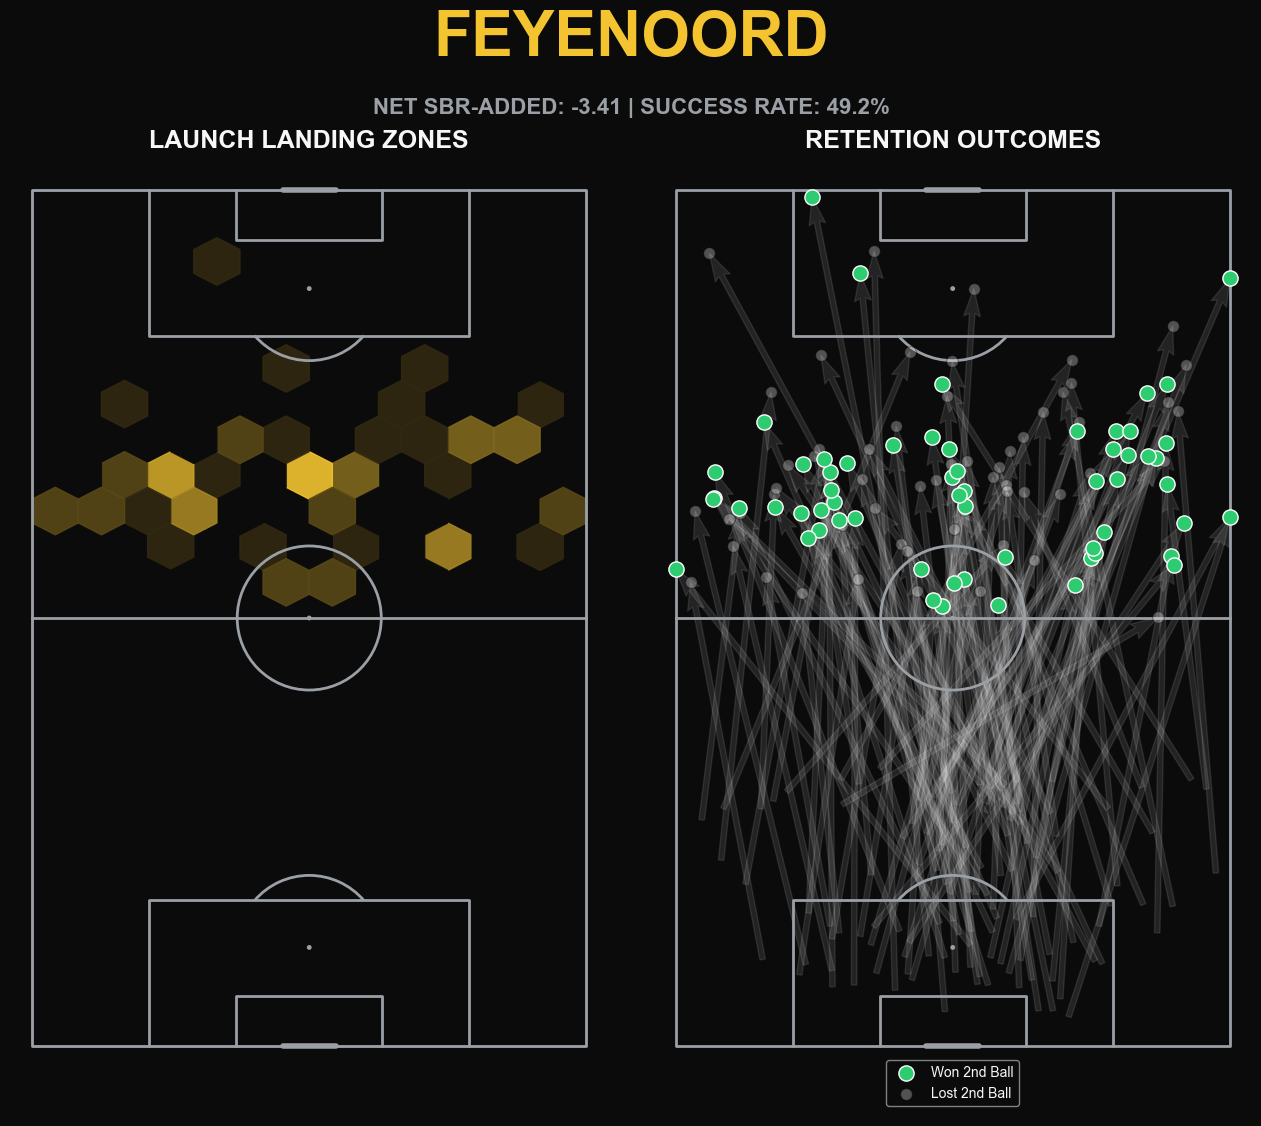

In [41]:
# --- EXECUTION ---
team_mapping = get_team_mapping(MAPPING_FILE)
raw_df = extract_launch_data(FOLDER_PATH, team_mapping)
final_df = run_sbr_model(raw_df)
plot_strategic_report(final_df, "Feyenoord")